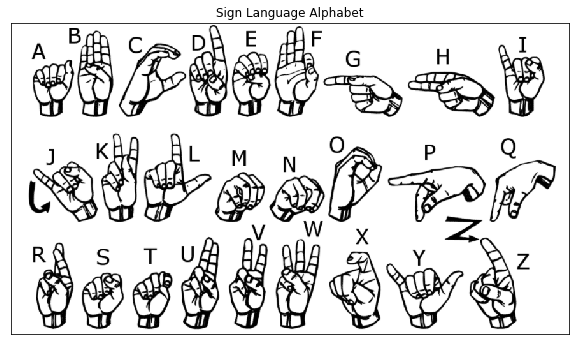

In [9]:
# My code base, check it out!
import matplotlib.pyplot as plt
import numpy as np
import AddisonCodeBase as acb

# Update figure size
plt.rcParams["figure.figsize"] = (10,10)

ims = [plt.imread('./american_sign_language.png'), acb.plt.imread('./amer_sign2.png'), acb.plt.imread('./amer_sign3.png')]
plt.title("Sign Language Alphabet")
plt.imshow(ims[0])
plt.xticks([])
plt.yticks([])
plt.show()

In [10]:
# Read the data in, already pre-plit into training and test
x_train, y_train = acb.read_data('sign_mnist_train.csv')
x_test, y_test = acb.read_data('sign_mnist_test.csv')
print("Number of training images: %d" % y_train.shape[0])
print("Number of test images: %d" % y_test.shape[0])

Number of training images: 27455
Number of test images: 7172


In [11]:
# Get the mappings from Labels to letters.
mappings = acb.get_mapping_dictionary(y_train)
print("Labels to Letters: ")
print(mappings)

Labels to Letters: 
{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}


Some random samples with their labels: 


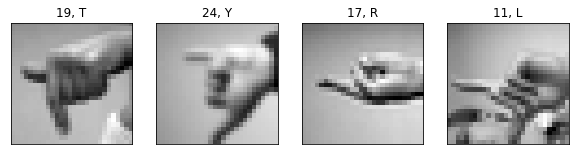

In [12]:
print("Some random samples with their labels: ")
fig, ax = plt.subplots(1,4)

randomind = np.random.choice(len(x_train), 4)
i = 0
plt.xticks([])
plt.yticks([])
for ind in randomind:
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title("%d, %s" % (y_train[ind], mappings[y_train[ind]]))
    ax[i].imshow(x_train[ind].squeeze(), cmap='gray')
    i += 1
fig.show()

In [13]:
slc = acb.SignLanguageClassifier(x_train, x_test, y_train, y_test)

In [14]:
slc.train()

Epoch: 1, Training Accuracy: 3.963, Test Accuracy: 4.838
Epoch: 2, Training Accuracy: 76.048, Test Accuracy: 65.756
Epoch: 3, Training Accuracy: 98.019, Test Accuracy: 88.246
Epoch: 4, Training Accuracy: 99.679, Test Accuracy: 88.720
Epoch: 5, Training Accuracy: 99.832, Test Accuracy: 89.933
Epoch: 6, Training Accuracy: 99.862, Test Accuracy: 90.951
Epoch: 7, Training Accuracy: 99.741, Test Accuracy: 90.365
Epoch: 8, Training Accuracy: 99.716, Test Accuracy: 91.523
Epoch: 9, Training Accuracy: 99.727, Test Accuracy: 91.662
Epoch: 10, Training Accuracy: 99.934, Test Accuracy: 92.722
Epoch: 11, Training Accuracy: 99.891, Test Accuracy: 92.248
Epoch: 12, Training Accuracy: 99.982, Test Accuracy: 92.192
Epoch: 13, Training Accuracy: 100.000, Test Accuracy: 94.060
Epoch: 14, Training Accuracy: 99.996, Test Accuracy: 93.656
Epoch: 15, Training Accuracy: 100.000, Test Accuracy: 93.767


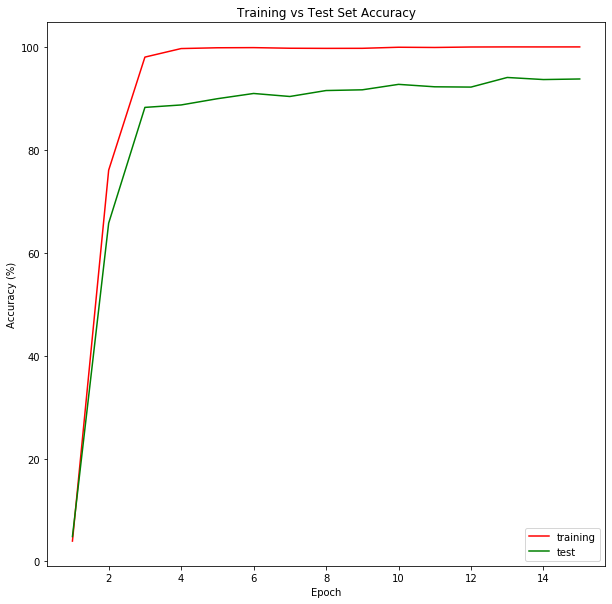

In [15]:
slc.train_test_chart()

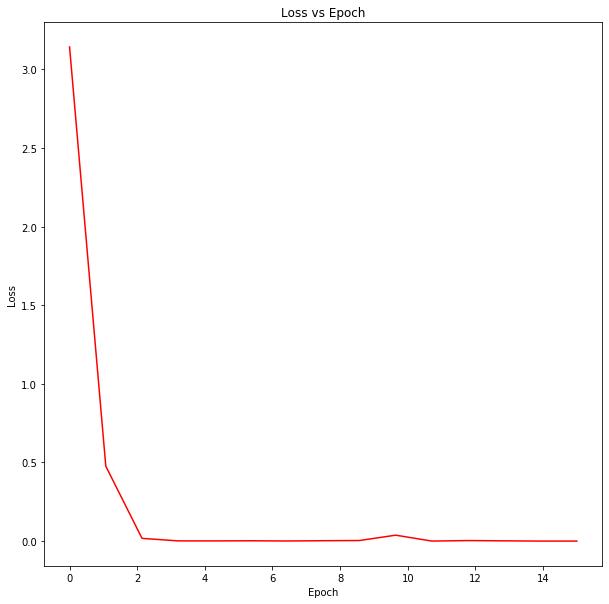

In [21]:
x = np.linspace(0,15,15)
loss = slc.loss
plt.title("Loss vs Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.plot(x, loss, 'r-')
plt.show()

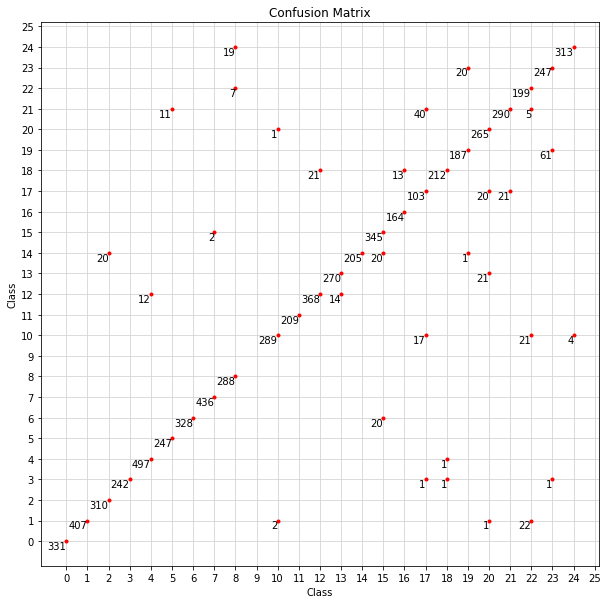

In [22]:
slc.show_confusion_matrix()

In [23]:
print("Class" + "\t" + "Letter")
for key in mappings.keys():
    print(str(key) + "\t" + mappings[key])

Class	Letter
0	A
1	B
2	C
3	D
4	E
5	F
6	G
7	H
8	I
9	J
10	K
11	L
12	M
13	N
14	O
15	P
16	Q
17	R
18	S
19	T
20	U
21	V
22	W
23	X
24	Y
25	Z


In [24]:
y_pred = slc.model(slc.x_test.float()).detach().numpy()

In [25]:
y_pred_test = []
for obs in y_pred:
    y_pred_test.append(np.argmax(obs))

y_pred_test = np.array(y_pred_test)

In [26]:
correct = 0
total = 0
for i,j in zip(y_pred_test, slc.y_test.detach().numpy()):
    if(i == j):
        correct += 1
    total += 1

print('Test set accuracy: %0.3f Percent' % (correct / total * 100))

Test set accuracy: 94.144 Percent


In [42]:
import torch
# Save the model, instead of retraining every time.
torch.save(slc.model.state_dict(), './pretrained.pt')
confusion_M = slc.confusion_M()

Precision	Recall		Letter
100.00		100.00		A
100.00		94.21		B
93.94		100.00		C
100.00		98.78		D
97.64		99.80		E
95.74		100.00		F
100.00		94.25		G
99.54		100.00		H
91.72		100.00		I
98.97		87.31		K
100.00		100.00		L
94.60		93.40		M
95.07		92.78		N
100.00		83.33		O
89.61		99.42		P
92.66		100.00		Q
63.98		71.53		R
99.07		86.18		S
89.90		75.40		T
86.32		99.62		U
93.25		83.82		V
80.57		96.60		W
79.94		92.51		X
98.74		94.28		Y


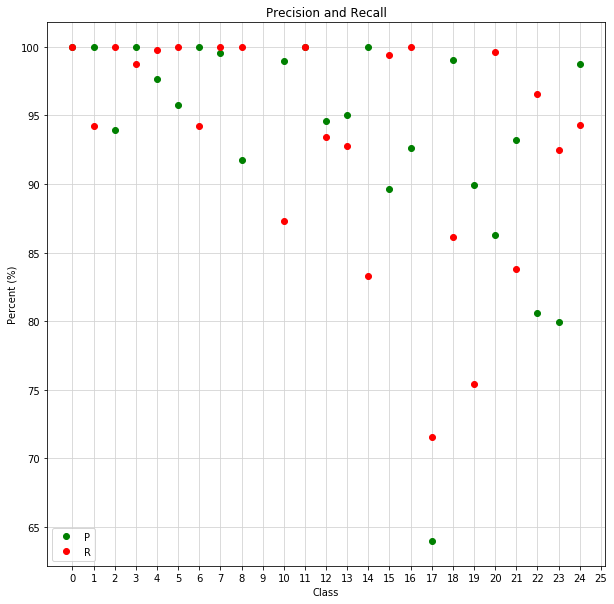

In [52]:
# Precision and Recall
precision = np.diag(confusion_M)/confusion_M.sum(axis=1)
recall = np.diag(confusion_M)/confusion_M.sum(axis=0)
plt.title("Precision and Recall")
print("Precision" + '\t' + "Recall" + '\t\t' + 'Letter')
for x in range(len(precision)):
    
    print("%0.2f" % (precision[x]*100), end='\t\t')
    print("%0.2f" % (recall[x]*100), end='\t\t')
    if(x >= 9):
        plt.plot(x+1, precision[x]*100,'go')
        plt.plot(x+1, recall[x]*100, 'ro')
        print(mappings[x+1], end='\n')
    else:
        plt.plot(x, precision[x]*100, 'go')
        plt.plot(x, recall[x]*100, 'ro')
        print(mappings[x], end='\n')
plt.xticks(np.linspace(0,25,26))
plt.legend("PR", loc='lower left')
plt.xlabel("Class")
plt.grid(b=False, linestyle='-', color='lightgray')
plt.ylabel("Percent (%)")
plt.show()

In [40]:
print("Avergae Precision: %0.2f" % (np.sum(precision) / len(precision) * 100))
print("Avergae Recall: %0.2f" % (np.sum(recall) / len(recall) * 100))

Avergae Precision: 93.39
Avergae Recall: 93.47


Predicted 17, Actual 21


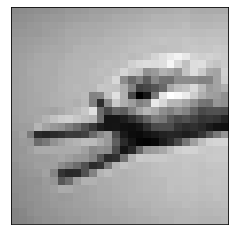

In [70]:
plt.rcParams["figure.figsize"] = (4,4)
i = 0
ims = []
for x,y in zip(y_test, y_pred_test):
    if(x == 21 and y == 17):
        ims.append(x_test[i].squeeze())
        
    i+=1

print("Predicted 17, Actual 21")
random = np.random.randint(0,len(ims))
plt.xticks([])
plt.yticks([])
plt.imshow(ims[random], cmap='gray')
plt.show()

Predicted 23, Actual 19


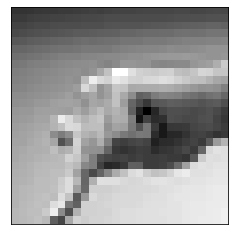

In [87]:
plt.rcParams["figure.figsize"] = (4,4)
i = 0
ims = []
for x,y in zip(y_test, y_pred_test):
    if(x == 19 and y == 23):
        ims.append(x_test[i].squeeze())
        
    i+=1

print("Predicted 23, Actual 19")
random = np.random.randint(0,len(ims))
plt.xticks([])
plt.yticks([])
plt.imshow(ims[random], cmap='gray')
plt.show()